In [1]:
from utilities.data_loader import load_modeling_data, load_testing_data
from utilities.text_cleaner import advanced_data_cleaning

In [2]:
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [3]:
train_data, train_labels = load_modeling_data()

In [4]:
train_data['text'] = train_data['text'].apply(advanced_data_cleaning)
# dict_val = {'negative': 0, 'neutral': 1, 'positive': 2}
# train_labels['target'] = train_labels['target'].apply(lambda x: dict_val[x])

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2,random_state=10)

In [6]:
length = [len(i) for i in train_data['text']]

In [7]:
print("The Average sentence length is", np.mean(length))
print("The Standard Deviation is", round(np.std(length)))
print(np.percentile(length, 95))

The Average sentence length is 85.40232216340502
The Standard Deviation is 44
160.0


In [8]:
# Creating Word Embeddings
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary

In [9]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [10]:
tk = Tokenizer(num_words=NB_WORDS,lower=True,split=" ")

In [11]:
full_df = pd.concat([X_train['text'], X_valid['text']], axis = 0)
tk.fit_on_texts(full_df)

In [12]:
X_train_seq = tk.texts_to_sequences(X_train['text'])

In [13]:
X_valid_seq = tk.texts_to_sequences(X_valid['text'])


In [14]:
seq_lengths = X_train['text'].apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    832258.000000
mean         15.093540
std           7.847509
min           1.000000
25%           9.000000
50%          14.000000
75%          21.000000
max         116.000000
Name: text, dtype: float64

In [15]:
np.percentile(seq_lengths, 95)

29.0

In [16]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=30)
X_valid_seq_trunc = pad_sequences(X_valid_seq, maxlen=30)

In [17]:
corpus=full_df.values
corpus = [x.split() for x in corpus]

In [18]:
from gensim.models import Word2Vec
print("Model Training Started...")
model = Word2Vec(sentences=corpus, vector_size=100, window=4, min_count=1, workers=4)

Model Training Started...


In [19]:
print("Total number of unique words loaded in Model : ", len(model.wv))
# model.wv.most_similar('laptop', topn=10)
model.save("word2vec-training.model")


Total number of unique words loaded in Model :  440612


In [20]:
vector_size = 100
gensim_weight_matrix = np.zeros((NB_WORDS ,vector_size))
gensim_weight_matrix.shape

(10000, 100)

In [21]:
for word, index in tk.word_index.items():
    if index < NB_WORDS: # since index starts with zero 
        if word in model.wv:
            gensim_weight_matrix[index] = model.wv[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [22]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

In [23]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train['target'])
y_valid_le = le.transform(y_valid['target'])
y_train_oh = to_categorical(y_train_le)
y_valid_oh = to_categorical(y_valid_le)

In [24]:
vocab_size = len(tk.word_index) + 1


In [25]:
emb_model = models.Sequential()
# emb_model.add(layers.Embedding(vocab_size, 64, input_length=30))
# emb_model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
# emb_model.add(layers.Flatten())
# emb_model.add(layers.Dense(3, activation='softmax'))

emb_model.add(Embedding(input_dim = NB_WORDS,
 output_dim = 100,
 input_length= X_train_seq_trunc.shape[1],
 weights = [gensim_weight_matrix],trainable = False))

# emb_model.add(Embedding(vocab_size, 64, input_length=30))
emb_model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
emb_model.add(Dropout(0.2))
emb_model.add(Bidirectional(LSTM(32)))
emb_model.add(Dropout(0.2))
emb_model.add(Dense(64, activation='relu'))
emb_model.add(Dropout(0.1))
emb_model.add(Dense(3, activation='softmax'))
emb_model.summary()


Metal device set to: Apple M1


2022-12-18 23:05:11.162030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-18 23:05:11.162706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [26]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_lstm_checkpoint.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid),
                       callbacks=[es])
    return history

In [27]:
NB_START_EPOCHS = 100
BATCH_SIZE = 512

In [28]:
emb_history = deep_model(emb_model, X_train_seq_trunc, y_train_oh, X_valid_seq_trunc, y_valid_oh)
# emb_history.history['val_acc'][-1]

Epoch 1/100


2022-12-18 23:05:14.759547: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-18 23:05:16.366029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 23:05:16.800705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 23:05:16.818885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 23:05:17.244574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 23:05:17.262659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 23:05:17.953134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

1626/1626 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.7924

2022-12-18 23:06:58.882005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 23:06:59.054925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 23:06:59.071408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 23:06:59.257718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 23:06:59.272432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1626/1626 [==============================] - 117s 70ms/step - loss: 0.4437 - accuracy: 0.7924 - val_loss: 0.4082 - val_accuracy: 0.8121
Epoch 2/100
1626/1626 [==============================] - 116s 72ms/step - loss: 0.4000 - accuracy: 0.8183 - val_loss: 0.3921 - val_accuracy: 0.8236
Epoch 3/100
1626/1626 [==============================] - 120s 74ms/step - loss: 0.3853 - accuracy: 0.8263 - val_loss: 0.3824 - val_accuracy: 0.8278
Epoch 4/100
1626/1626 [==============================] - 112s 69ms/step - loss: 0.3755 - accuracy: 0.8314 - val_loss: 0.3785 - val_accuracy: 0.8307
Epoch 5/100
1626/1626 [==============================] - 119s 73ms/step - loss: 0.3682 - accuracy: 0.8353 - val_loss: 0.3725 - val_accuracy: 0.8332
Epoch 6/100
1626/1626 [==============================] - 109s 67ms/step - loss: 0.3620 - accuracy: 0.8384 - val_loss: 0.3733 - val_accuracy: 0.8333
Epoch 7/100
1626/1626 [==============================] - 109s 67ms/step - loss: 0.3566 - accuracy: 0.8411 - val_loss: 0.3718

In [29]:
emb_history.history['val_accuracy'][-1]

0.8335520625114441

In [30]:
import seaborn as sns
sns.set_theme(context="notebook", palette=("deep"))

In [31]:
def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, len(emb_history.history['val_accuracy'])+1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.title('Training '+metric_name+' vs validation '+metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

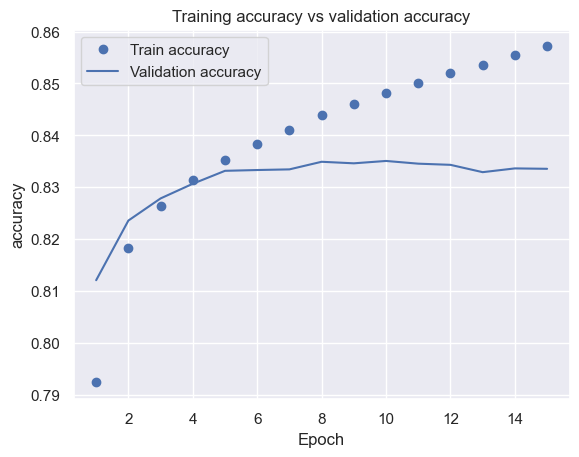

In [32]:
eval_metric(emb_history, 'accuracy')


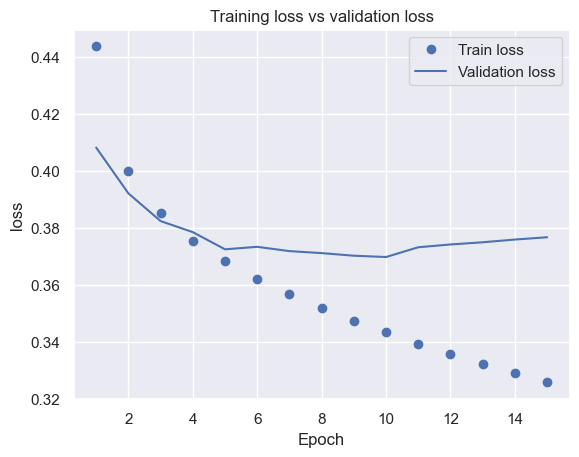

In [33]:
eval_metric(emb_history, 'loss')